
# 📘 C5.1.1 — Analyse du besoin (Bloc 5)

**But de la compétence :** décrire clairement la **problématique**, le **contexte**, les **contraintes** (coût/délai/complexité) et les **points de vigilance**, en s'appuyant sur une **première exploration des données** (EDA) et en définissant des **KPI**.

---

## 🎙️ Discours (prêt à l'oral — 1 à 2 minutes)
> « Nous voulons dépasser l'analyse sentiment binaire sur les avis Amazon pour extraire des **insights actionnables** : émotions, aspects produit (points forts/faibles), et ironie.  
> Le **contexte** : catégorie *Electronics* Amazon (cut & volume importants), consommation locale (Jupyter/PC), démo Streamlit.  
> Les **décisions** visées : prioriser des améliorations produit, enrichir les fiches, orienter le SAV et détecter des tendances.  
> **Contraintes** : latence de démo (<200 ms sur baseline), reproductibilité, anonymisation, et qualité variable des avis.  
> **Points de vigilance** vus dès l’EDA : avis très courts/dupliqués, déséquilibre de notes, dates manquantes/incohérentes, biais lexicaux.  
> On fige ici des **KPI** qui guideront la suite : F1-macro (émotions/ABSA), AUC (ironie), couverture et latence. »

---


## ⚙️ 0) Configuration & chemins

In [1]:

from pathlib import Path

# Chemin du CSV (adapter si besoin)
CSV_PATH = Path("C:/Users/antoi/OneDrive/Documents/Ynov/Projet fil rouge/Bloc 5/amazon-reviews-insights/data/amazon_insights.csv")

# Dossier de sortie pour les figures/rapport
DOCS_DIR = Path("docs")
FIGS_DIR = DOCS_DIR / "figs"
DOCS_DIR.mkdir(parents=True, exist_ok=True)
FIGS_DIR.mkdir(parents=True, exist_ok=True)

CSV_PATH, FIGS_DIR

(WindowsPath('C:/Users/antoi/OneDrive/Documents/Ynov/Projet fil rouge/Bloc 5/amazon-reviews-insights/data/amazon_insights.csv'),
 WindowsPath('docs/figs'))

## 🧱 1) Normalisation du schéma (robuste à différents dumps Amazon)

In [2]:

import pandas as pd
import numpy as np

assert CSV_PATH.exists(), f"CSV introuvable : {CSV_PATH}"
df = pd.read_csv(CSV_PATH, low_memory=False)

# 1) Renommer vers des noms canoniques
rename_map = {}
if "text" in df.columns:   rename_map["text"]   = "review_body"
if "rating" in df.columns: rename_map["rating"] = "star_rating"
if "date" in df.columns:   rename_map["date"]   = "review_date"
df = df.rename(columns=rename_map)

# Titre du commentaire et nom produit
if "title_x" in df.columns:
    df["review_title"] = df["title_x"].astype(str).str.strip()
if "title_y" in df.columns:
    df["product_title"] = df["title_y"].astype(str).str.strip()

# Identifiant produit
if "parent_asin" in df.columns:
    df["product_id"] = df["parent_asin"].astype(str)
elif "asin" in df.columns:
    df["product_id"] = df["asin"].astype(str)

# Date à partir de timestamp si besoin
def ts_to_datetime(series):
    s = pd.to_numeric(series, errors="coerce")
    if s.notna().sum() == 0:
        return pd.to_datetime(pd.NaT)
    med = float(s.dropna().median())
    unit = "ms" if med > 1e12 else "s"
    return pd.to_datetime(s, unit=unit, errors="coerce")

if "review_date" not in df.columns and "timestamp" in df.columns:
    df["review_date"] = ts_to_datetime(df["timestamp"])

# Types minimaux
assert "review_body" in df.columns, "Colonne texte manquante (ex 'text')."
assert "star_rating" in df.columns, "Colonne note manquante (ex 'rating')."

df["review_body"] = df["review_body"].astype(str)
df["star_rating"] = pd.to_numeric(df["star_rating"], errors="coerce")

# Champs utiles
if "helpful_vote" in df.columns:
    df["helpful_vote"] = pd.to_numeric(df["helpful_vote"], errors="coerce").fillna(0).astype(int)
if "verified_purchase" in df.columns and df["verified_purchase"].dtype != bool:
    df["verified_purchase"] = df["verified_purchase"].astype(str).str.lower().isin(["true","1","y","yes"])

# Feature utilitaire
df["review_len"] = df["review_body"].str.len()

# Supprimer d'éventuels doublons de noms
if df.columns.duplicated().any():
    df = df.loc[:, ~df.columns.duplicated()]

df.shape, df.columns.tolist()[:12]

((1314720, 22),
 ['Unnamed: 0',
  'star_rating',
  'title_x',
  'review_body',
  'asin',
  'parent_asin',
  'user_id',
  'timestamp',
  'helpful_vote',
  'verified_purchase',
  'main_category',
  'title_y'])

## 🔎 2) Aperçu & qualité (contexte)

In [3]:
# Aperçu de quelques lignes
df.sample(3, random_state=42)[["review_body","review_title","product_title","star_rating"]]

,review_body,review_title,product_title,star_rating
145322,This Hub was clearly designed for Apple comput...,Outstanding USB Hub made of REAL aluminum,Premium Aluminum 4 Port USB Hub - Sleek Apple-...,5.0
1110436,Works as advertised,It works,"12Ft TV Power Cord, Monitor Power Cable, PC Co...",5.0
301223,Good so far! Only had for 1 week. Clips for st...,Durable,"Soke Galaxy Tab A 10.1 Case 2019, Premium Shoc...",5.0


In [4]:
# Résumé des types et mémoire (affiché sous forme de texte)
import io, sys
buf = io.StringIO()
df.info(buf=buf, memory_usage="deep")
print(buf.getvalue()[:1500])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314720 entries, 0 to 1314719
Data columns (total 22 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Unnamed: 0         1314720 non-null  int64  
 1   star_rating        1314720 non-null  float64
 2   title_x            1314720 non-null  object 
 3   review_body        1314720 non-null  object 
 4   asin               1314720 non-null  object 
 5   parent_asin        1314720 non-null  object 
 6   user_id            1314720 non-null  object 
 7   timestamp          1314720 non-null  int64  
 8   helpful_vote       1314720 non-null  int64  
 9   verified_purchase  1314720 non-null  bool   
 10  main_category      1314720 non-null  object 
 11  title_y            1314720 non-null  object 
 12  average_rating     1314720 non-null  float64
 13  rating_number      1314720 non-null  int64  
 14  features           1314720 non-null  object 
 15  store              1314720 non-n

In [5]:
df

,Unnamed: 0,star_rating,title_x,review_body,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,...,average_rating,rating_number,features,store,categories,review_date,review_title,product_title,product_id,review_len
0,0,5.0,Five Stars,All OK and as described.,B005FAPYXS,B005FAPYXS,AES2QJS66UB66K2C7MNRDSEOOGAQ,1423080806000,0,True,...,4.5,224,"['10 XT60 Connectors - Five Male, Five Female'...",OOOUSE,['Electronics' 'Home Audio' 'Home Audio Access...,2015-02-04 20:13:26.000,Five Stars,OOOUSE XT60 Connector Pairs - Pack of 5 pairs,B005FAPYXS,24
1,1,5.0,Five Stars,Great but how can you go wrong.,B005FAPYXS,B005FAPYXS,AE5W7TDLLOZD62AGZRS56SOM7KOA,1471740518000,0,True,...,4.5,224,"['10 XT60 Connectors - Five Male, Five Female'...",OOOUSE,['Electronics' 'Home Audio' 'Home Audio Access...,2016-08-21 00:48:38.000,Five Stars,OOOUSE XT60 Connector Pairs - Pack of 5 pairs,B005FAPYXS,31
2,2,1.0,Very poor manufacturing,Don't waste your money!! Connectors won't plu...,B005FAPYXS,B005FAPYXS,AF76HWTTIDICDKSGWLHROHVXO4HA,1488815637000,1,True,...,4.5,224,"['10 XT60 Connectors - Five Male, Five Female'...",OOOUSE,['Electronics' 'Home Audio' 'Home Audio Access...,2017-03-06 15:53:57.000,Very poor manufacturing,OOOUSE XT60 Connector Pairs - Pack of 5 pairs,B005FAPYXS,84
3,3,5.0,No good reason to use Deans plugs with these s...,Well made. No good reason to use Deans plugs w...,B005FAPYXS,B005FAPYXS,AEU2XSPD3DNY56EYOQEZRGQ6J6TA,1422054178000,0,True,...,4.5,224,"['10 XT60 Connectors - Five Male, Five Female'...",OOOUSE,['Electronics' 'Home Audio' 'Home Audio Access...,2015-01-23 23:02:58.000,No good reason to use Deans plugs with these s...,OOOUSE XT60 Connector Pairs - Pack of 5 pairs,B005FAPYXS,87
4,4,5.0,Great buy!,I used it in everything! All my b useless quad...,B005FAPYXS,B005FAPYXS,AH6NJEUWK3KK3XHTOZDTFC7DO2HQ,1465304707000,0,True,...,4.5,224,"['10 XT60 Connectors - Five Male, Five Female'...",OOOUSE,['Electronics' 'Home Audio' 'Home Audio Access...,2016-06-07 13:05:07.000,Great buy!,OOOUSE XT60 Connector Pairs - Pack of 5 pairs,B005FAPYXS,112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314715,1339952,5.0,"Great price, good performance",Is a great cable for a few bucks,B09B739SMG,B09B8NXVBK,AFQIEX47OGDKMTCZBLGYCI3CI2QA,1643827478722,0,True,...,3.8,15,['【Perfect function-4k HDMI cable】 kinseda 4k ...,kinseda,['Electronics' 'Television & Video' 'Accessori...,2022-02-02 18:44:38.722,"Great price, good performance","kinseda 4K HDMI Cable,HDMI 2.0 Cable 10ft CL3 ...",B09B8NXVBK,32
1314716,1339953,2.0,Buggy router firmware,I had to return the router because the wired c...,B0000BZO5U,B0000BZO5U,AHS2DGD66MWQNJ3QT5CF2FZTO4WA,1070653411000,7,False,...,3.0,19,['Intelligent software automatically detects y...,Microsoft,[],2003-12-05 19:43:31.000,Buggy router firmware,Microsoft Wireless-G Notebook Kit,B0000BZO5U,627
1314717,1339954,5.0,Fluance: My new favorite items ever bought on ...,I purchased this speaker and the XL7F pair as ...,B00AQL9B2G,B00AQL9B2G,AETQ6CG4ZEF34P77V3FSVP4YOB6A,1405571757000,0,False,...,4.3,50,['Enhance the vocals and dialogue of your favo...,Fluance,['Electronics' 'Home Audio' 'Speakers' 'Center...,2014-07-17 04:35:57.000,Fluance: My new favorite items ever bought on ...,Fluance XL7C High Performance Two-Way Center C...,B00AQL9B2G,527
1314718,1339955,5.0,Works great on Windows 10,"Works great on Windows 10, without any driver....",B07CNPJDRW,B07CNPJDRW,AGK2BPEL76ZZLEZJ73364AFJU4GA,1578767058206,0,True,...,3.9,56,['Add Bluetooth connectivity to your desktop o...,IOGEAR,['Electronics' 'Computers & Accessories' 'Netw...,2020-01-11 18:24:18.206,Works great on Windows 10,IOGEAR Bluetooth 4.0 Dual-Mode USB Mini Adapte...,B07CNPJDRW,225


In [6]:

# Taux de valeurs manquantes par colonne (top 12)
miss = df.isna().mean().sort_values(ascending=False).head(12).to_frame("pct_missing")
miss


,pct_missing
Unnamed: 0,0.0
star_rating,0.0
title_x,0.0
review_body,0.0
asin,0.0
parent_asin,0.0
user_id,0.0
timestamp,0.0
helpful_vote,0.0
verified_purchase,0.0


## 📊 3) Distributions clés (notes, longueur, verified, helpful)

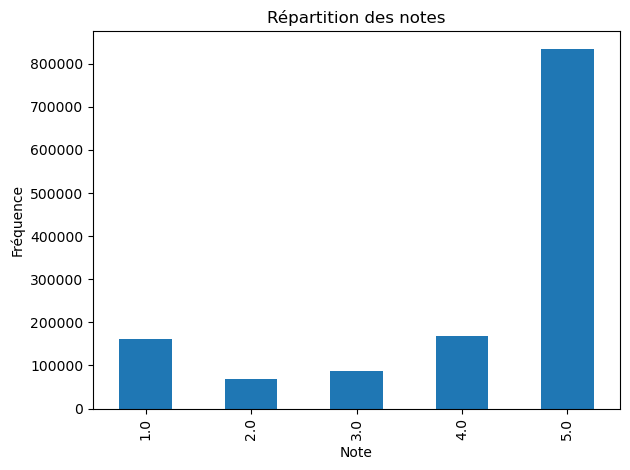

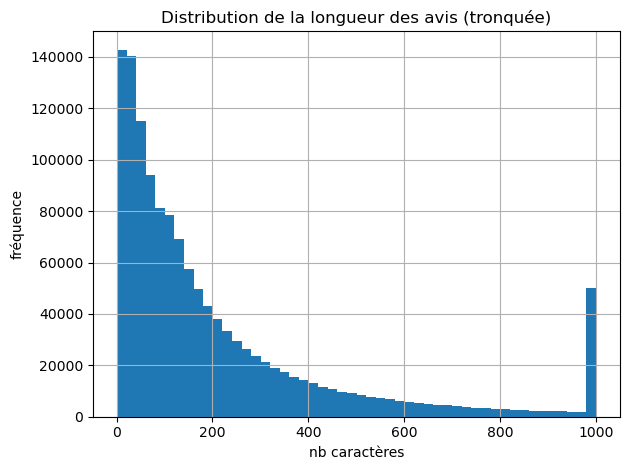

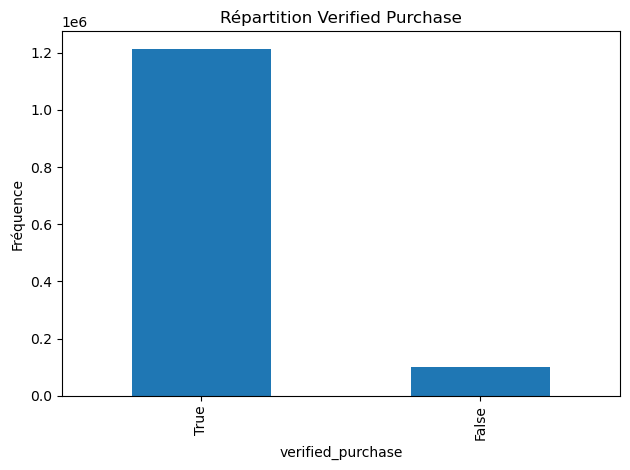

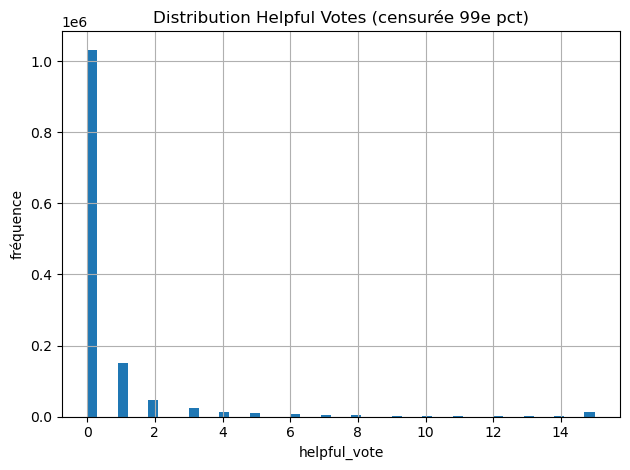

In [7]:

import matplotlib.pyplot as plt

# Répartition des notes
df["star_rating"].value_counts().sort_index().plot(kind="bar", title="Répartition des notes")
plt.xlabel("Note"); plt.ylabel("Fréquence"); plt.tight_layout(); plt.savefig(FIGS_DIR/"ratings_bar.png"); plt.show()

# Longueur des avis (tronquée pour la lisibilité)
df["review_len"].clip(0,1000).hist(bins=50)
plt.title("Distribution de la longueur des avis (tronquée)")
plt.xlabel("nb caractères"); plt.ylabel("fréquence"); plt.tight_layout(); plt.savefig(FIGS_DIR/"review_len_hist.png"); plt.show()

# Verified purchase si présent
if "verified_purchase" in df.columns:
    df["verified_purchase"].value_counts().plot(kind="bar", title="Répartition Verified Purchase")
    plt.xlabel("verified_purchase"); plt.ylabel("Fréquence"); plt.tight_layout(); plt.savefig(FIGS_DIR/"verified_bar.png"); plt.show()

# Helpful votes (troncature quantile 99%)
if "helpful_vote" in df.columns:
    cap = df["helpful_vote"].quantile(0.99)
    df["helpful_vote"].clip(0, cap).hist(bins=50)
    plt.title("Distribution Helpful Votes (censurée 99e pct)")
    plt.xlabel("helpful_vote"); plt.ylabel("fréquence"); plt.tight_layout(); plt.savefig(FIGS_DIR/"helpful_hist.png"); plt.show()


## ⏱️ 4) Évolution temporelle (si dates disponibles)

In [8]:
# Vérifier le dtype
print("dtype avant:", df["review_date"].dtype)

# Convertir proprement en datetime (gère les ".000", etc.)
df["review_date"] = pd.to_datetime(df["review_date"], errors="coerce")

print("dtype après:", df["review_date"].dtype)
print("NaT (%) :", df["review_date"].isna().mean())

dtype avant: object
dtype après: datetime64[ns]
NaT (%) : 0.0


C:\Users\antoi\AppData\Local\Temp\ipykernel_34860\3464425272.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index("review_date").resample("M").size()


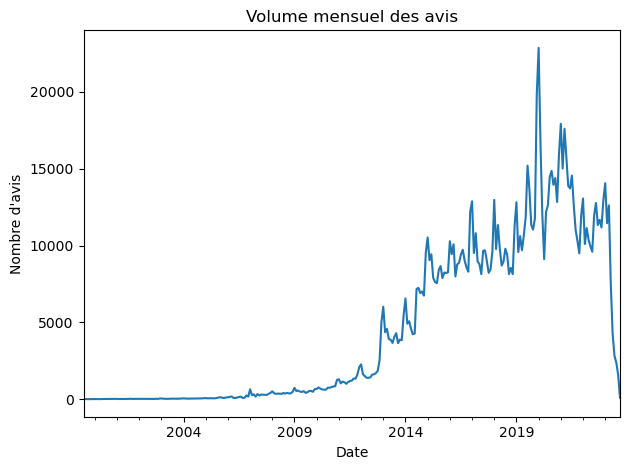

In [9]:

if "review_date" in df.columns:
    monthly = df.set_index("review_date").resample("M").size()
    monthly.plot(title="Volume mensuel des avis")
    plt.xlabel("Date"); plt.ylabel("Nombre d'avis"); plt.tight_layout(); plt.savefig(FIGS_DIR/"monthly_volume.png"); plt.show()
else:
    print("Pas de colonne review_date disponible.")

## 🧪 5) Qualité : doublons & incohérences

In [10]:

# Heuristique de doublon : même user + produit + texte (si colonnes dispo)
keys = [c for c in ["user_id","product_id","review_body"] if c in df.columns]
if set(keys) == set(["user_id","product_id","review_body"]):
    dup_mask = df.duplicated(subset=keys, keep=False)
    print("Doublons potentiels (user_id, product_id, review_body) :", int(dup_mask.sum()))
else:
    print("Colonnes insuffisantes pour détecter des doublons (user_id/product_id manquants).")

Doublons potentiels (user_id, product_id, review_body) : 1058


## 🛒 6) Vue produit / catégorie (top)

In [11]:

# Top produits par volume (si product_id dispo)
if "product_id" in df.columns:
    top_products = df["product_id"].value_counts().head(10).to_frame("nb_reviews")
    top_products
else:
    print("Pas de product_id pour vue produit.")

# Top catégories si dispo
if "main_category" in df.columns:
    top_cats = df["main_category"].value_counts().head(10).to_frame("nb_reviews")
    top_cats


## 🎯 7) KPI cibles (serviront aux compétences suivantes)

In [12]:

import pandas as pd
kpi = pd.DataFrame([
    {"KPI": "Émotions F1-macro", "Cible": 0.60, "Usage": "Nuances du ressenti"},
    {"KPI": "ABSA F1-macro", "Cible": 0.60, "Usage": "Polarité par aspect"},
    {"KPI": "Sarcasme AUC", "Cible": 0.75, "Usage": "Ironie/Sarcasme"},
    {"KPI": "Latence de prédiction (ms)", "Cible": 200, "Usage": "Démo / UX"},
    {"KPI": "Couverture reviews (%)", "Cible": 95, "Usage": "Taux de prédictions non-null"}
])
kpi

,KPI,Cible,Usage
0,Émotions F1-macro,0.60,Nuances du ressenti
1,ABSA F1-macro,0.60,Polarité par aspect
2,Sarcasme AUC,0.75,Ironie/Sarcasme
3,Latence de prédiction (ms),200.00,Démo / UX
4,Couverture reviews (%),95.00,Taux de prédictions non-null



## ⚠️ 8) Contraintes & points de vigilance (à reprendre dans le livrable)
- **Contraintes** : calcul local (CPU/GPU), taille des données, latence de démo, reproductibilité, anonymisation.
- **Vigilance données** : avis très courts, doublons, dates manquantes, *verified_purchase* absent sur certains enregistrements, dérives temporelles possibles.
- **Vigilance modèles** : déséquilibres de classes, biais lexicaux, sur-apprentissage, ironie difficile à capter.
- **Mesures** : filtrage longueur `review_len`, dédoublonnage, split temporel si pertinent, calibration des seuils, monitoring (drift).

---


## 📝 9) Export automatique du livrable C5.1.1 (Markdown)

In [13]:

from textwrap import dedent
import json

stats = {
    "n_rows": int(len(df)),
    "pct_short_<20": float((df['review_len'] < 20).mean()),
    "rating_min": float(df['star_rating'].min()) if 'star_rating' in df.columns else None,
    "rating_max": float(df['star_rating'].max()) if 'star_rating' in df.columns else None,
    "has_dates": bool("review_date" in df.columns),
    "has_verified": bool("verified_purchase" in df.columns),
    "has_helpful": bool("helpful_vote" in df.columns),
}

md = f"""# C5.1.1 — Analyse du besoin

## Problématique
Aller au-delà du sentiment binaire pour extraire **émotions**, **aspects produit** et **ironie** à partir des avis Amazon (*Electronics*).

## Contexte
- Données : {CSV_PATH}
- Schéma normalisé : `review_body`, `star_rating`, `review_date`, `review_title`, `product_title`, `product_id`
- Taille : {stats['n_rows']:,} avis

## Contraintes
- Exécution locale, latence démo < 200 ms (baseline)
- Reproductibilité (notebooks, configs), anonymisation

## Points de vigilance (issus de l'EDA)
- Textes courts (<20 chars) : {stats['pct_short_<20']:.2%}
- Notes min/max : {stats['rating_min']}..{stats['rating_max']}
- Dates présentes : {stats['has_dates']}; Verified : {stats['has_verified']}; Helpful : {stats['has_helpful']}

## KPI cibles
- Émotions F1-macro ≥ 0.60 ; ABSA F1-macro ≥ 0.60 ; Sarcasme AUC ≥ 0.75 ; Latence ≤ 200 ms ; Couverture ≥ 95%

## Décisions supportées
- Priorisation d'améliorations produit, enrichissement des fiches, priorités SAV, veille des tendances.

(Annexes : figures dans `docs/figs/`)
"""

out_path = DOCS_DIR / "01_analyse_du_besoin.md"
out_path.write_text(md, encoding="utf-8")
out_path

WindowsPath('docs/01_analyse_du_besoin.md')

In [14]:
# === 1.x — Sauvegarde du dataset normalisé pour C5.1.2 ===

INTERIM_DIR = Path("data/interim")
INTERIM_DIR.mkdir(parents=True, exist_ok=True)

PARQUET_OUT = INTERIM_DIR / "amazon_electronics_normalized.parquet"
CSV_OUT     = INTERIM_DIR / "amazon_electronics_normalized.csv"

# Colonnes utiles qu'on conserve si elles existent
keep_cols = [c for c in [
    "review_body","review_title","star_rating","review_date",
    "product_title","product_id","helpful_vote","verified_purchase",
    "main_category","categories","user_id"
] if c in df.columns]

# Copie + sécurisation des dtypes
df_norm = df.copy()

df_norm["review_body"] = df_norm["review_body"].astype(str)
df_norm["star_rating"] = pd.to_numeric(df_norm["star_rating"], errors="coerce")

if "review_date" in df_norm.columns:
    df_norm["review_date"] = pd.to_datetime(df_norm["review_date"], errors="coerce")

if "helpful_vote" in df_norm.columns:
    df_norm["helpful_vote"] = (
        pd.to_numeric(df_norm["helpful_vote"], errors="coerce")
        .fillna(0).astype("int64")
    )

if "verified_purchase" in df_norm.columns and df_norm["verified_purchase"].dtype != bool:
    df_norm["verified_purchase"] = (
        df_norm["verified_purchase"].astype(str).str.lower()
        .isin(["true","1","y","yes"])
    )

df_norm = df_norm[keep_cols]

# Écriture Parquet (rapide & garde les types), sinon fallback CSV si pyarrow absent
try:
    df_norm.to_parquet(PARQUET_OUT, index=False)
    print("✅ Écrit (parquet) :", PARQUET_OUT, "| lignes :", len(df_norm))
except Exception as e:
    print("ℹ️ Parquet indisponible → écriture CSV. Raison :", e)
    df_norm.to_csv(CSV_OUT, index=False)
    print("✅ Écrit (csv) :", CSV_OUT, "| lignes :", len(df_norm))

df_norm.head(3)

✅ Écrit (parquet) : data\interim\amazon_electronics_normalized.parquet | lignes : 1314720


,review_body,review_title,star_rating,review_date,product_title,product_id,helpful_vote,verified_purchase,main_category,categories,user_id
0,All OK and as described.,Five Stars,5.0,2015-02-04 20:13:26,OOOUSE XT60 Connector Pairs - Pack of 5 pairs,B005FAPYXS,0,True,Industrial & Scientific,['Electronics' 'Home Audio' 'Home Audio Access...,AES2QJS66UB66K2C7MNRDSEOOGAQ
1,Great but how can you go wrong.,Five Stars,5.0,2016-08-21 00:48:38,OOOUSE XT60 Connector Pairs - Pack of 5 pairs,B005FAPYXS,0,True,Industrial & Scientific,['Electronics' 'Home Audio' 'Home Audio Access...,AE5W7TDLLOZD62AGZRS56SOM7KOA
2,Don't waste your money!! Connectors won't plu...,Very poor manufacturing,1.0,2017-03-06 15:53:57,OOOUSE XT60 Connector Pairs - Pack of 5 pairs,B005FAPYXS,1,True,Industrial & Scientific,['Electronics' 'Home Audio' 'Home Audio Access...,AF76HWTTIDICDKSGWLHROHVXO4HA



## ✅ 10) Checklist d'évaluation (à cocher)
- [x] **Problématique** explicitée et reliée aux décisions métier  
- [x] **Contexte** (données, périmètre, parties prenantes)  
- [x] **Contraintes** (coût/délai/complexité/latence/reproductibilité)  
- [x] **Points de vigilance** identifiés via EDA  
- [x] **KPI** et critères d’acceptation définis  
- [x] **Livrable** exporté : `docs/01_analyse_du_besoin.md` + figures `docs/figs/`



---

### 🔒 Rappel à la compétence & pourquoi c'est validé
- Le **besoin** est explicité (au-delà du binaire, insights riches).  
- Le **contexte** et les **contraintes** sont décrits, avec impacts sur la stratégie.  
- Les **points de vigilance** proviennent d'une **EDA concrète** (stats & graphes).  
- Les **KPI** sont **clairs** et serviront à piloter la suite (C5.1.2, C5.2.x).  
- Un **livrable** conforme est **généré automatiquement** dans `docs/`.
